# 문제1

## 패키지

In [22]:
from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

import sys
sys.path.append("../../../")
from helper import set_datetime_index, exp_time_data

## 데이터 준비

In [23]:
origin = read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx")
origin.head()

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9


## 데이터 타입 확인

In [24]:
origin.dtypes

날짜         datetime64[ns]
평균기온(℃)           float64
dtype: object

## 날짜 인덱스 설정

외부에서 가져온 데이터는 무조건 문자열

데이터의 dtype을 분석에 맞게 변경, index를 잡아줌

In [25]:
df = set_datetime_index(origin, '날짜')
df.head()

,평균기온(℃)
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


## 결측치 검사

In [26]:
df.isna().sum()

평균기온(℃)    0
dtype: int64

## 데이터 검정

> 데이터가 너무 방대해서 최신 5년 데이터로 검정 진행

In [27]:
# 1년 365일
df2 = df.tail(365*5)
df2.head()

,평균기온(℃)
2018-08-08,31.0
2018-08-09,28.8
2018-08-10,30.7
2018-08-11,31.0
2018-08-12,30.6


exp_time_data 설명

데이터에 0 값이 있을 때 exp_time_data에서 "m"으로 설정했을 때 에러가 나면 "a"로 잡아준다.

max_diff로 최대 차분 횟수 설정.<br/>
데이터가 상승 값이면 곱셈 방식으로 "m".<br/>
데이터가 하강 값이면 덧셈 방식으로 "a".<br/>
exp_time_data(df, '종속변수', "m", max_diff=최대 차분 횟수)

In [28]:
df2.columns

Index(['평균기온(℃)'], dtype='object')

결측치 수: 0


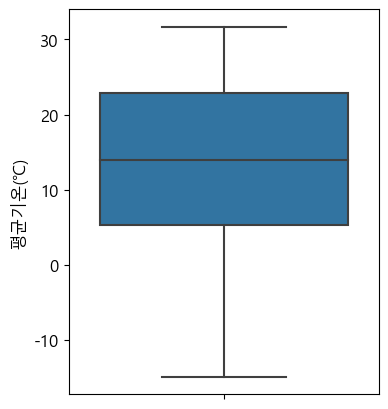

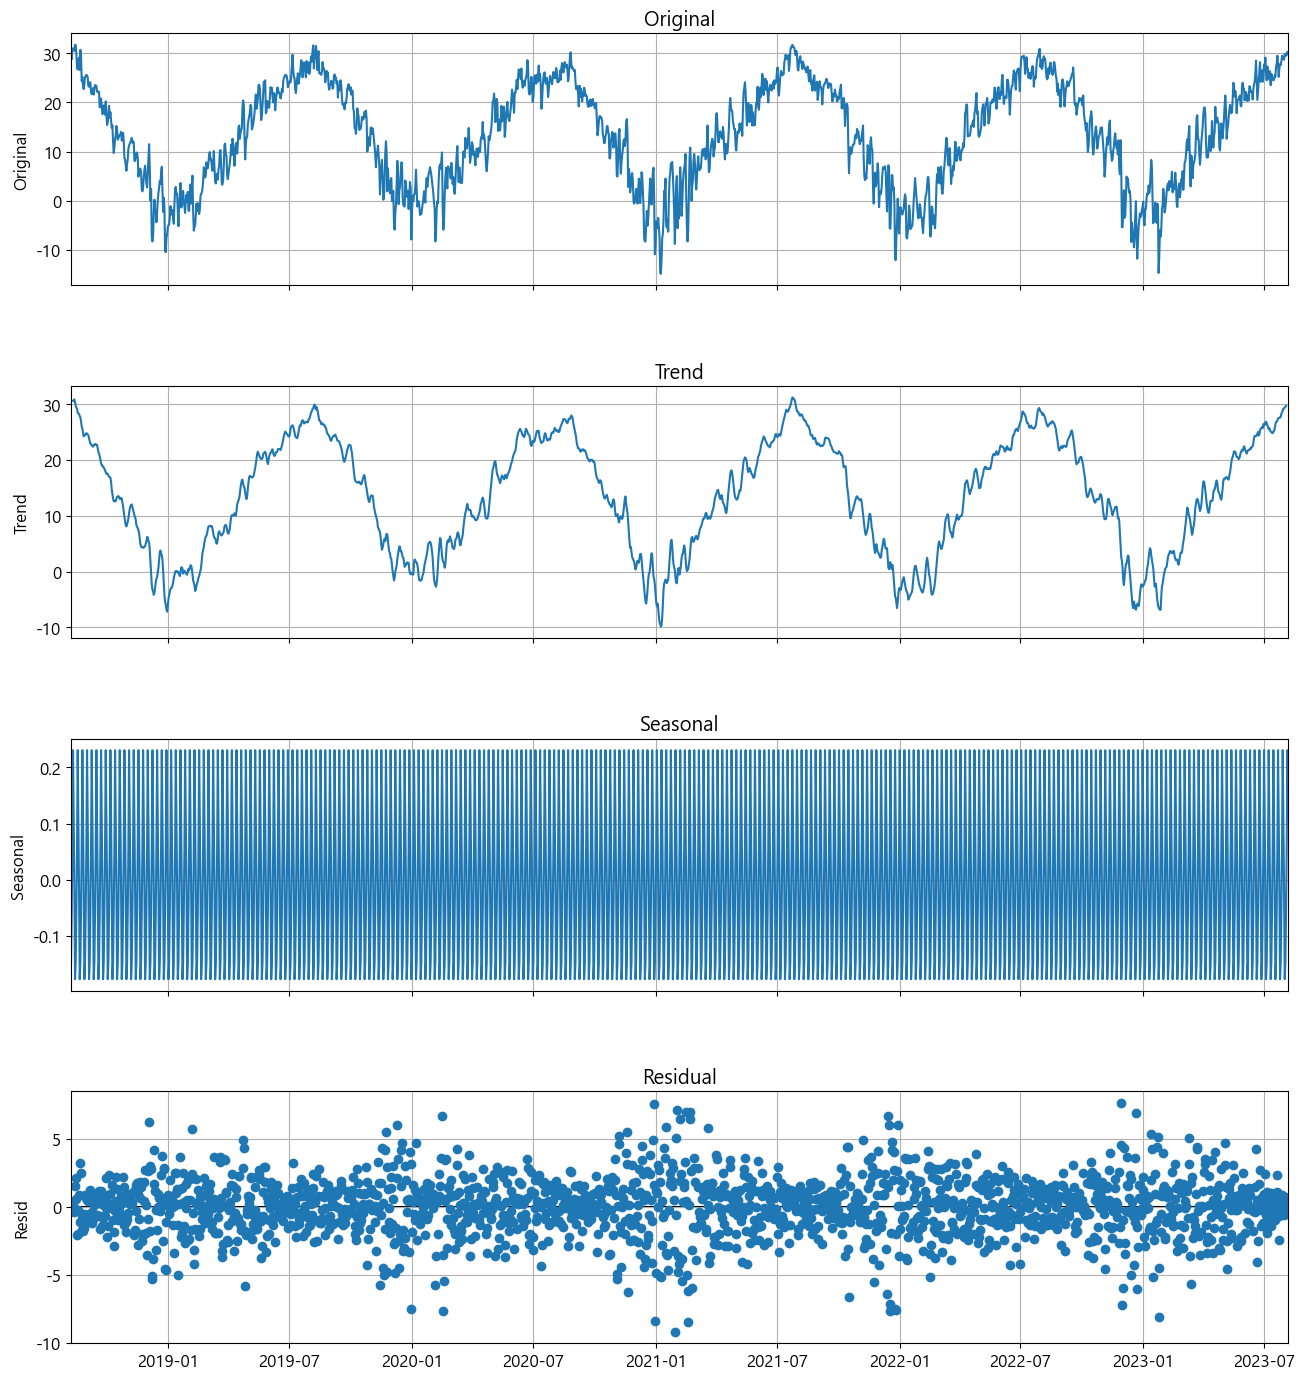

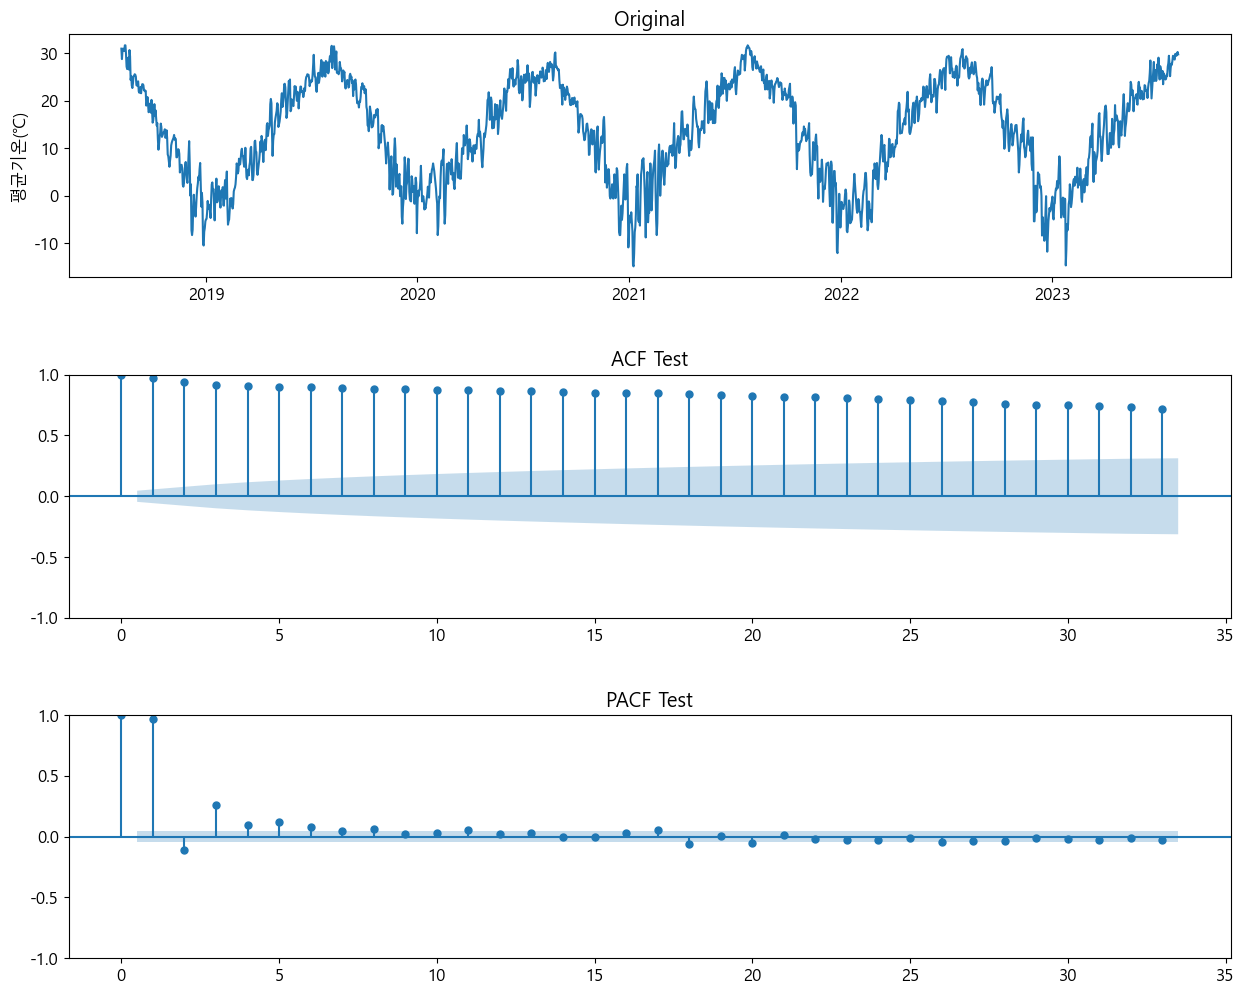

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -2.00483 |
| 유의수준(p-value)                  | 0.284458 |
| 최적차수(num of lags)              |       19 |
| 관측치 개수(num of observations)   |     1805 |
| 기각값(Critical Values) 1%         | -3.43398 |
| 기각값(Critical Values) 5%         | -2.86314 |
| 기각값(Critical Values) 10%        | -2.56762 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+
=========== 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -11.4068 |
| 유의수준(p-value)                  | 7.41633e-21 |
| 최적차수(num of lags)              |          18 |
| 관측치 개수(num of observations)   |        1805 |
| 기각값(Critical Va

In [29]:
# exp_time_data(data=df2, yname="평균기온(℃)", sd_model="a", max_diff=10)
exp_time_data(data=df2, yname='평균기온(℃)', sd_model="a", max_diff=10)

## #`ACF, PACF 검정 기준`

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |

`추가` - 쉬운 설명
| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 완만 | 상대적으로 급격 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |
| 적합 모델 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |

model = ARIMA(df['독립변수'], order=(p,d,q), seasonal_order=(p,d,q,s))</br>
d는 차분 횟수, p/q는 ACF, PACF 검정 기준을 통해 확인

계절성 고려 -> seasonal_order=(P,D,Q,s) - 계절성이란 주기

계절성은 분석가가 직접 판단 - 여러번 도전(반 노가다)

## ARIMA 분석

### 분석 모델 만들기

> 날씨에 대한 데이터이므로 계절성은 1년마다 돌아온다고 보는 것이 맞지만 컴퓨터 성능상의 한계로 계절성을 1주일 단위(=7일)로 제한함

In [30]:
#----------------------------------------
# 함부로 주기성 365로 잡지 말 것 - PC가 죽음(맥북쓰면 해결-CPU 성능이 죽여줌)
#----------------------------------------
model = ARIMA(df2['평균기온(℃)'], order=(1,1,0), seasonal_order=(1,1,0,31))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                 1825
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 31)   Log Likelihood               -4497.716
Date:                          Tue, 08 Aug 2023   AIC                           9001.433
Time:                                  17:10:20   BIC                           9017.908
Sample:                              08-08-2018   HQIC                          9007.516
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1017      0.021      4.813      0.000       0.060       0.143
ar.S.L31      -0.4993      0.016    -30.560      0.

## 학습 모델에 대한 예측치

In [31]:
fv = fit.fittedvalues
fv.head()

2018-08-08     0.000000
2018-08-09    31.000019
2018-08-10    28.799999
2018-08-11    30.700002
2018-08-12    31.000001
Freq: D, dtype: float64

## 학습한 내용을 토대로 1년간의 예상치 생성

In [32]:
fc = fit.forecast(365)
fc.head()

2023-08-07    28.737531
2023-08-08    28.719427
2023-08-09    27.767814
2023-08-10    30.016729
2023-08-11    28.564814
Freq: D, Name: predicted_mean, dtype: float64

## 시각화

시각화 시 여유공간을 제공하지 않으면 그래프가 너무 꽉 차게되서 가시성이 떨어짐

In [33]:
last = df.index.max()
xmin = last - timedelta(days=365)
xmax = last + timedelta(days=365+10)
ymax = df['평균기온(℃)'][xmin:xmax].max()
ymin = df['평균기온(℃)'][xmin:xmax].min()
xmin, xmax, ymax, ymin

(Timestamp('2022-08-06 00:00:00'),
 Timestamp('2024-08-15 00:00:00'),
 30.3,
 -14.7)

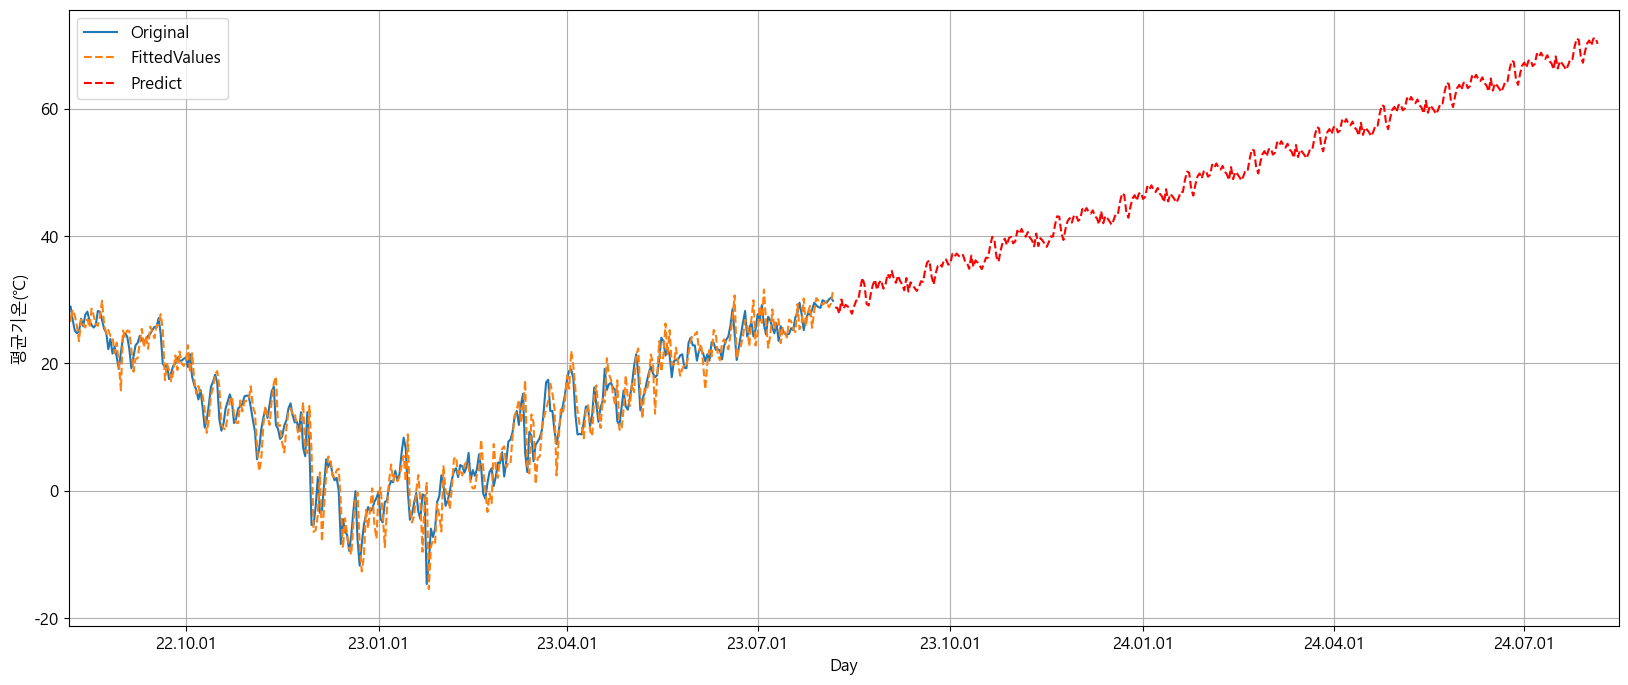

In [35]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df, x=df.index, y='평균기온(℃)', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 1년간의 예측 값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel("Day")
plt.ylabel("평균기온(℃)")
plt.legend()

plt.xlim([xmin, xmax])
# plt.ylim([ymin * 0.8, ymax*1.2])  #y축 건드리면 이상해짐

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

## 결론

분석 실패

> 컴퓨터의 성능 문제로 계절성(주기)를 맞추지 않은게 패착